In [1]:
import mlflow
import pandas as pd
import mlflow.sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np

In [2]:
df = pd.read_csv("online_retail.csv")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df.shape

(541909, 8)

In [4]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
df["InvoiceNo"].astype(str).str.contains("C", na=False).sum()

np.int64(9288)

In [6]:
(df["Quantity"] < 0).sum()

np.int64(10624)

In [7]:
def remove_invalid_quantity_price(df):
    """Remove rows with Quantity <= 0 or UnitPrice <= 0."""
    df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]
    return df


def remove_cancelled_invoices(df):
    """Remove cancelled invoices (InvoiceNo starting with 'C')."""
    df = df[~df["InvoiceNo"].astype(str).str.startswith("C")]
    return df


def remove_missing_customer(df):
    """Remove rows with missing CustomerID."""
    df = df.dropna(subset=["CustomerID"])
    return df

In [8]:
def lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    text = text.split()
    text = [lemmatizer.lemmatize(word) for word in text]
    return " ".join(text)


def remove_stop_words(text):
    stop_words = set(stopwords.words("english"))
    text = [word for word in str(text).split() if word not in stop_words]
    return " ".join(text)


def removing_numbers(text):
    return ''.join([char for char in text if not char.isdigit()])


def lower_case(text):
    return text.lower()


def removing_punctuations(text):
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\s+', ' ', text).strip()
    return text


def removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [9]:
def normalize_description(df):
    """Normalize Description column."""
    try:
        df["Description"] = df["Description"].astype(str)
        df["Description"] = df["Description"].apply(lower_case)
        df["Description"] = df["Description"].apply(remove_stop_words)
        df["Description"] = df["Description"].apply(removing_numbers)
        df["Description"] = df["Description"].apply(removing_punctuations)
        df["Description"] = df["Description"].apply(removing_urls)
        df["Description"] = df["Description"].apply(lemmatization)
        return df
    except Exception as e:
        print(f"Error during Description normalization: {e}")
        raise

In [10]:
def preprocess_ecommerce_data(df):
    """Full preprocessing pipeline for ecommerce dataset."""

    df = remove_invalid_quantity_price(df)
    df = remove_cancelled_invoices(df)
    df = remove_missing_customer(df)
    df = normalize_description(df)

    return df

In [11]:
df = preprocess_ecommerce_data(df)

In [12]:
df.shape

(397884, 8)

In [13]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [14]:
df["InvoiceNo"].astype(str).str.contains("C", na=False).sum()

np.int64(0)

In [15]:
(df["Quantity"] < 0).sum()

np.int64(0)

In [16]:
country_volume = df.groupby("Country")["InvoiceNo"].nunique().sort_values(ascending=False)

print(country_volume.head(10))

Country
United Kingdom    16646
Germany             457
France              389
EIRE                260
Belgium              98
Netherlands          94
Spain                90
Portugal             57
Australia            57
Switzerland          51
Name: InvoiceNo, dtype: int64


<Axes: title={'center': 'Top 10 Countries by Transactions'}, xlabel='Country'>

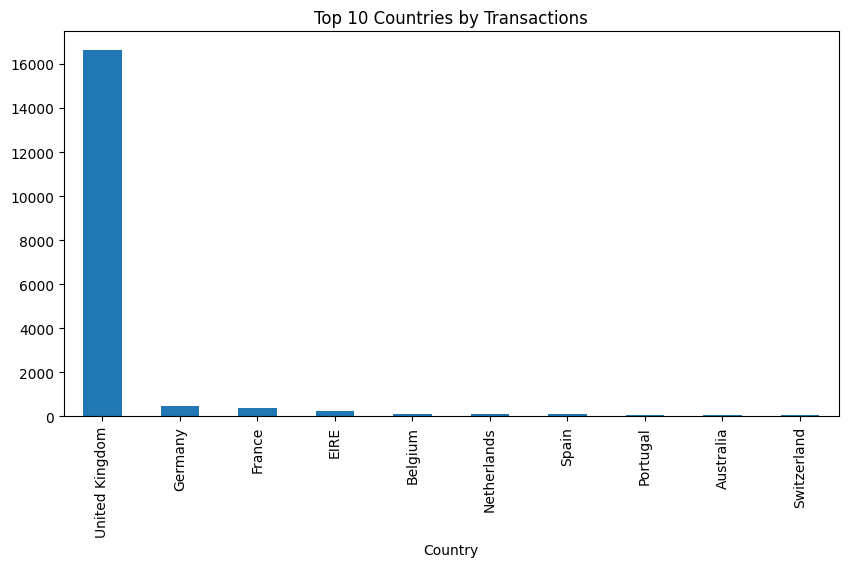

In [17]:
country_volume.head(10).plot(kind="bar", figsize=(10,5), title="Top 10 Countries by Transactions")

In [18]:
df["Country"].value_counts().head(10)

Country
United Kingdom    354321
Germany             9040
France              8341
EIRE                7236
Spain               2484
Netherlands         2359
Belgium             2031
Switzerland         1841
Portugal            1462
Australia           1182
Name: count, dtype: int64

In [19]:
top_products = df.groupby("Description")["Quantity"].sum().sort_values(ascending=False)
print(top_products.head(20))

Description
paper craft little birdie             80995
medium ceramic top storage jar        77916
world war glider asstd design         54415
jumbo bag red retrospot               46181
white hanging heart t light holder    36725
assorted colour bird ornament         35362
pack retrospot cake case              33693
popcorn holder                        30931
rabbit night light                    27202
mini paint set vintage                26076
pack london tissue                    25345
pack pink paisley cake case           24264
brocade ring purse                    22963
victorian glass hanging t light       22433
assorted colour silk fan              21876
red harmonica box                     20975
jumbo bag pink polkadot               20165
small popcorn holder                  18252
lunch bag red retrospot               17697
teatime fairy cake case               17689
Name: Quantity, dtype: int64


<Axes: title={'center': 'Top Selling Products'}, ylabel='Description'>

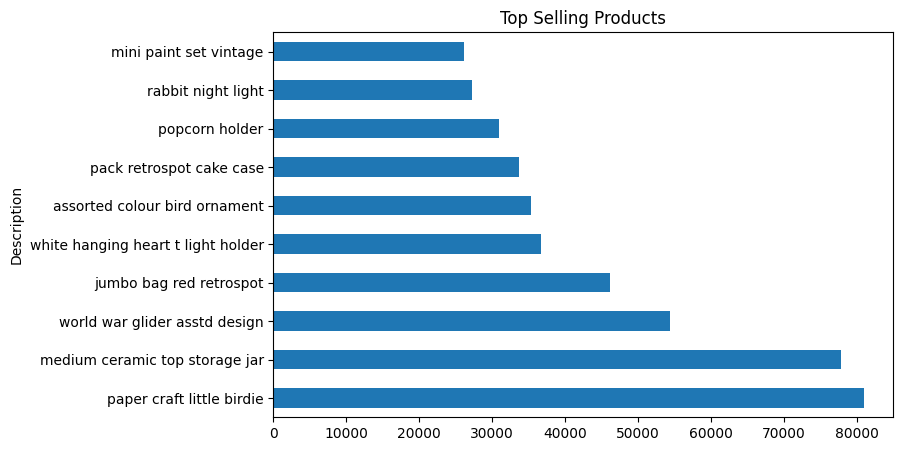

In [20]:
top_products.head(10).plot(kind="barh", figsize=(8,5), title="Top Selling Products")

<Axes: title={'center': 'Daily Purchase Trend'}, xlabel='InvoiceDate'>

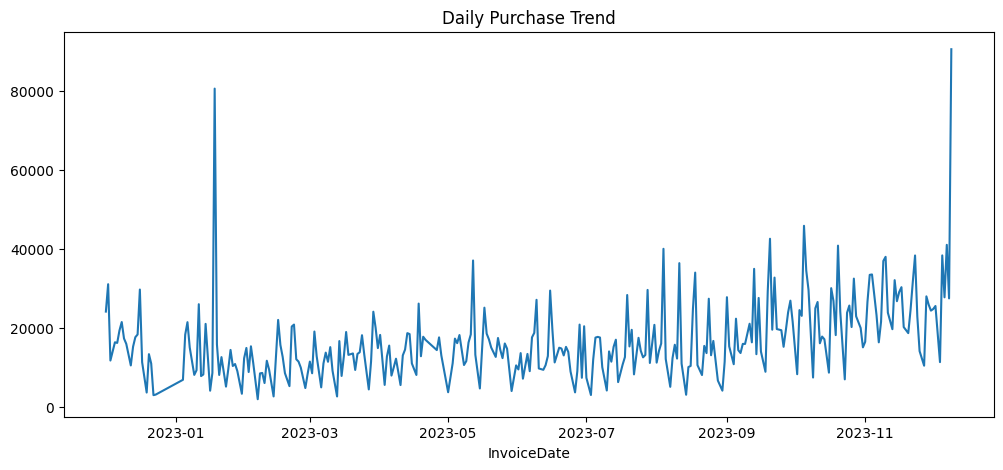

In [21]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

daily_sales = df.groupby(df["InvoiceDate"].dt.date)["Quantity"].sum()

daily_sales.plot(figsize=(12,5), title="Daily Purchase Trend")

<Axes: >

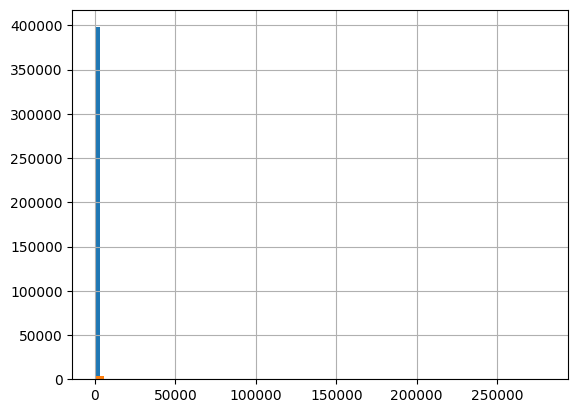

In [22]:
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]
df["TotalPrice"].hist(bins=50)
df.groupby("CustomerID")["TotalPrice"].sum().hist(bins=50)

In [23]:
import datetime as dt

snapshot_date = df["InvoiceDate"].max() + dt.timedelta(days=1)

rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,
    "InvoiceNo": "nunique",
    "TotalPrice": "sum"
})

rfm.columns = ["Recency", "Frequency", "Monetary"]

rfm.head(10)


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40
12352.0,36,8,2506.04
12353.0,204,1,89.00
12354.0,232,1,1079.40
12355.0,214,1,459.40


In [24]:
df["CustomerID"].nunique()

4338

In [25]:
# customer_country = df.groupby("CustomerID")["Country"].agg(lambda x: x.mode()[0])

# rfm = rfm.merge(customer_country, left_index=True, right_index=True)

In [26]:
# rfm["Country"].value_counts()

In [27]:
rfm["Monetary"].describe()

count      4338.000000
mean       2054.266460
std        8989.230441
min           3.750000
25%         307.415000
50%         674.485000
75%        1661.740000
max      280206.020000
Name: Monetary, dtype: float64

array([[<Axes: title={'center': 'Recency'}>,
        <Axes: title={'center': 'Frequency'}>],
       [<Axes: title={'center': 'Monetary'}>, <Axes: >]], dtype=object)

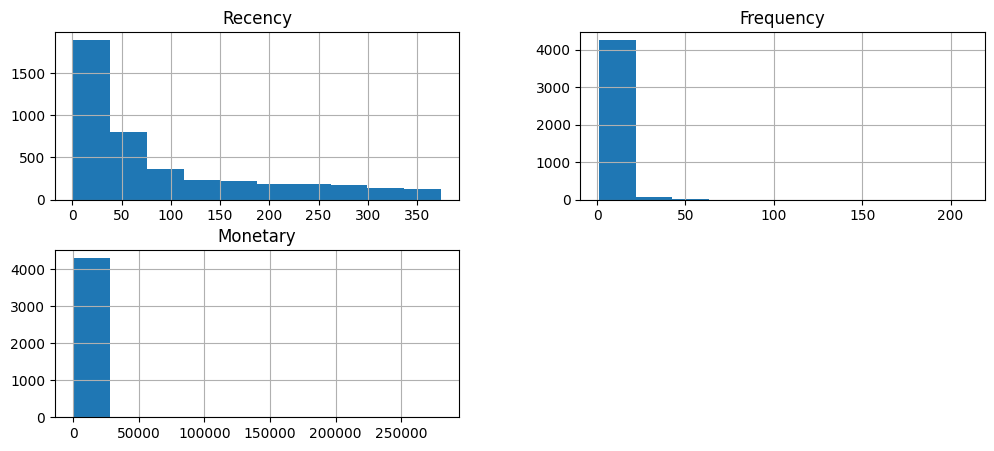

In [28]:
rfm.hist(figsize=(12,5))

Text(0, 0.5, 'WCSS')

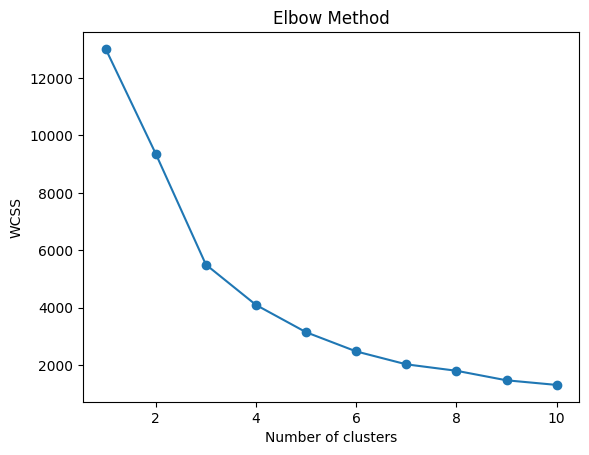

In [29]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

wcss = []

for k in range(1,11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,11), wcss, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")

In [30]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm["Cluster"] = kmeans.fit_predict(rfm_scaled)

cluster_profile = rfm.groupby("Cluster").mean()
print(cluster_profile)

            Recency  Frequency       Monetary
Cluster                                      
0         43.702685   3.682711    1359.049284
1        248.075914   1.552015     480.617480
2          7.384615  82.538462  127338.313846
3         15.500000  22.333333   12709.090490


<Axes: xlabel='Cluster'>

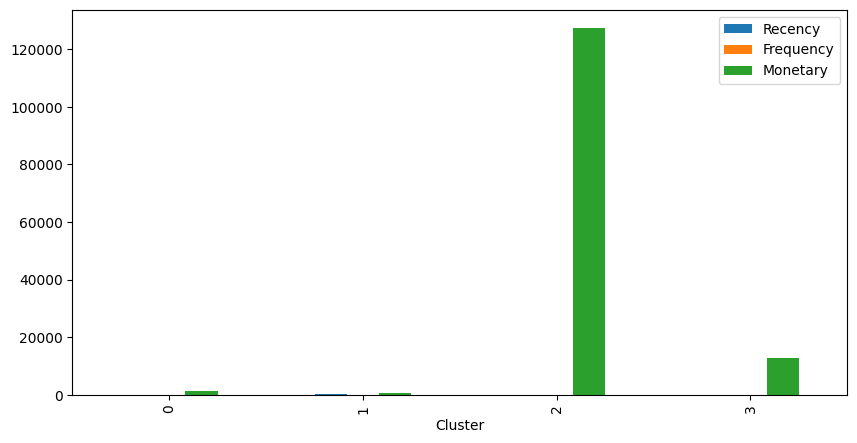

In [31]:
cluster_profile.plot(kind="bar", figsize=(10,5))

In [32]:
user_item = df.pivot_table(index="CustomerID", columns="Description", values="Quantity", fill_value=0)

In [33]:
from sklearn.metrics.pairwise import cosine_similarity

product_similarity = cosine_similarity(user_item.T)
product_similarity_df = pd.DataFrame(product_similarity, index=user_item.columns, columns=user_item.columns)

Text(0.5, 1.0, 'Product Similarity Heatmap')

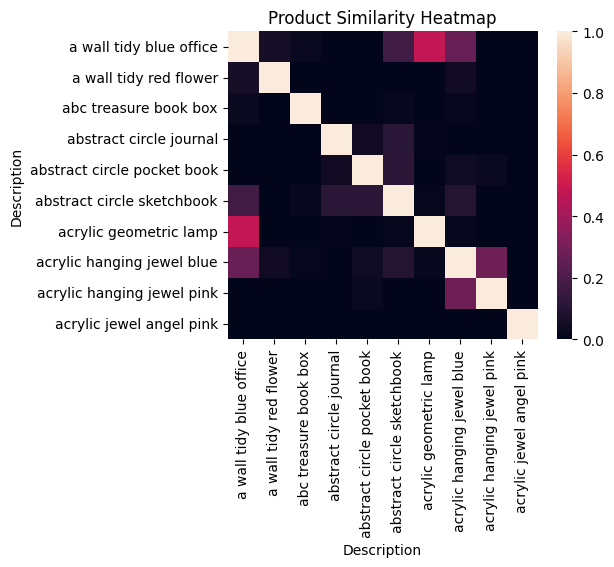

In [34]:
import seaborn as sns

plt.figure(figsize=(5,4))
sns.heatmap(product_similarity_df.iloc[:10,:10])
plt.title("Product Similarity Heatmap")

In [35]:
import datetime as dt

# Convert date
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# Create TotalPrice
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

# Snapshot date
snapshot_date = df["InvoiceDate"].max() + dt.timedelta(days=1)

# RFM calculation
rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,  # Recency
    "InvoiceNo": "nunique",                                   # Frequency
    "TotalPrice": "sum"                                       # Monetary
})

rfm.columns = ["Recency", "Frequency", "Monetary"]

rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


In [36]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

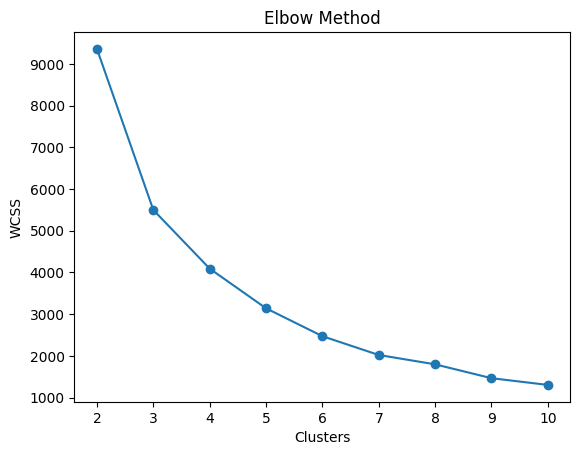

In [37]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
for k in range(2,11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(2,11), wcss, marker='o')
plt.xlabel("Clusters")
plt.ylabel("WCSS")
plt.title("Elbow Method")
plt.show()

In [38]:
from sklearn.metrics import silhouette_score

for k in range(2,11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    print(f"K={k} -> Silhouette Score: {score:.3f}")

K=2 -> Silhouette Score: 0.560
K=3 -> Silhouette Score: 0.585
K=4 -> Silhouette Score: 0.616
K=5 -> Silhouette Score: 0.617
K=6 -> Silhouette Score: 0.598
K=7 -> Silhouette Score: 0.517
K=8 -> Silhouette Score: 0.491
K=9 -> Silhouette Score: 0.484
K=10 -> Silhouette Score: 0.425


In [39]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm["Cluster"] = kmeans.fit_predict(rfm_scaled)
cluster_profile = rfm.groupby("Cluster").mean()
cluster_profile

,Recency,Frequency,Monetary
Cluster,,,
0,43.702685,3.682711,1359.049284
1,248.075914,1.552015,480.617480
2,7.384615,82.538462,127338.313846
3,15.500000,22.333333,12709.090490


In [40]:
def label_segment(row):
    if row["Recency"] < rfm["Recency"].median() and row["Frequency"] > rfm["Frequency"].median() and row["Monetary"] > rfm["Monetary"].median():
        return "High-Value"
    elif row["Frequency"] > rfm["Frequency"].median():
        return "Regular"
    elif row["Recency"] > rfm["Recency"].median():
        return "At-Risk"
    else:
        return "Occasional"

rfm["Segment"] = rfm.apply(label_segment, axis=1)

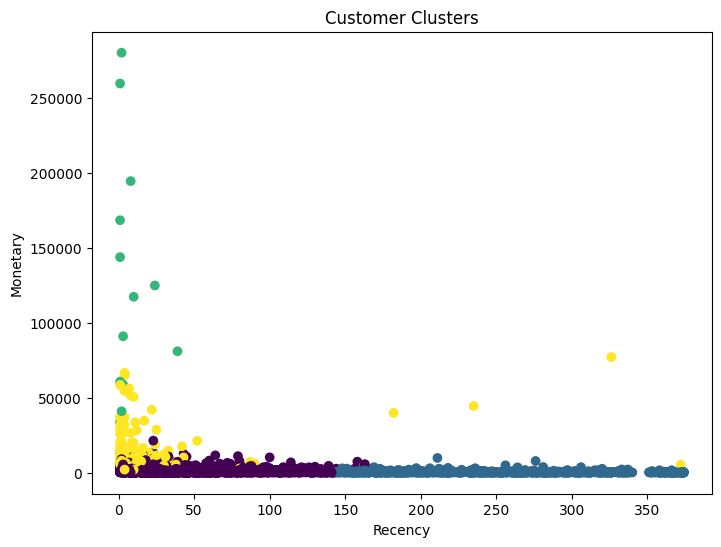

In [41]:
plt.figure(figsize=(8,6))
plt.scatter(rfm["Recency"], rfm["Monetary"], c=rfm["Cluster"])
plt.xlabel("Recency")
plt.ylabel("Monetary")
plt.title("Customer Clusters")
plt.show()

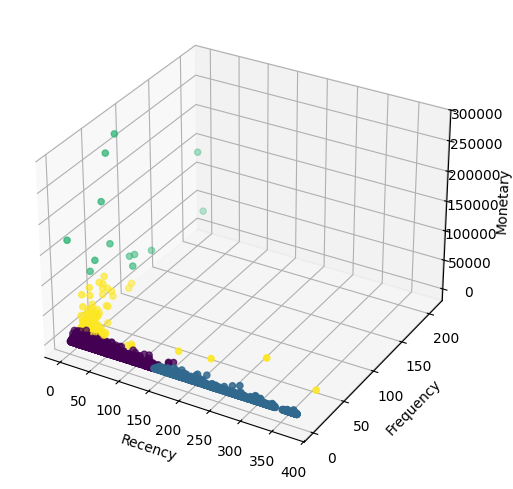

In [42]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(rfm["Recency"], rfm["Frequency"], rfm["Monetary"], c=rfm["Cluster"])
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")

plt.show()

In [43]:
product_similarity_df.columns[:20]

Index(['a wall tidy blue office', 'a wall tidy red flower',
       'abc treasure book box', 'abstract circle journal',
       'abstract circle pocket book', 'abstract circle sketchbook',
       'acrylic geometric lamp', 'acrylic hanging jewel blue',
       'acrylic hanging jewel pink', 'acrylic jewel angel pink',
       'acrylic jewel icicle blue', 'acrylic jewel icicle pink',
       'acrylic jewel snowflake pink', 'adult apron apple delight',
       'advent calendar gingham sack', 'afghan slipper sock pair',
       'aged glass silver t light holder', 'airline bag vintage jet set brown',
       'airline bag vintage jet set red', 'airline bag vintage jet set white'],
      dtype='object', name='Description')

In [44]:
def recommend_products(product_name, similarity_df, n=5):
    product_name = product_name.strip().upper()
    
    # map columns to uppercase for matching
    col_map = {col.upper(): col for col in similarity_df.columns}
    
    if product_name not in col_map:
        return f"Product '{product_name}' not found in dataset."
    
    real_name = col_map[product_name]
    
    return similarity_df[real_name].sort_values(ascending=False)[1:n+1]

In [45]:
recommend_products("GREEN AKER", product_similarity_df)

"Product 'GREEN AKER' not found in dataset."

In [46]:
import pickle

# Save KMeans model
pickle.dump(kmeans, open("kmeans_model.pkl", "wb"))

# Save Scaler
pickle.dump(scaler, open("scaler.pkl", "wb"))

# Save Product Similarity Matrix
pickle.dump(product_similarity_df, open("product_similarity.pkl", "wb"))

print("Models exported successfully!")

Models exported successfully!
